## Credit Card Fraud Test Overview
The datasets contains transactions made by credit cards in September 2013 by european cardholders. The whole dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
## Step 1: load lib and dataset

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

print(os.getcwd())

C:\Users\Xianhui\Documents\Python Scripts


In [2]:
df_raw = pd.read_csv('./Data/fraud_data.csv')
Amount = df_raw.Amount.copy()
# print(df_raw.info(), '\n')
print(df_raw.describe().transpose())

          count       mean         std        min       25%        50%  \
V1      21693.0  -0.032403    2.106997 -41.928738 -0.929371   0.007545   
V2      21693.0   0.047565    1.690911 -40.803981 -0.592921   0.075215   
V3      21693.0  -0.091623    1.870289 -31.103685 -0.962975   0.176534   
V4      21693.0   0.057805    1.540329  -4.848504 -0.850069  -0.012868   
V5      21693.0  -0.033983    1.530508 -32.092129 -0.698296  -0.063948   
V6      21693.0  -0.023207    1.340599 -20.367836 -0.779041  -0.281565   
V7      21693.0  -0.074203    1.596775 -41.506796 -0.565297   0.030859   
V8      21693.0   0.002096    1.412650 -38.987263 -0.205943   0.023159   
V9      21693.0  -0.044311    1.158554 -13.434066 -0.669752  -0.073996   
V10     21693.0  -0.091073    1.354886 -24.403185 -0.554596  -0.099291   
V11     21693.0   0.067173    1.154227  -3.995739 -0.739193   0.005596   
V12     21693.0  -0.094268    1.364933 -18.553697 -0.438730   0.126666   
V13     21693.0  -0.000667    0.989655

## Step 2: Exploratory analysis and preprocessing

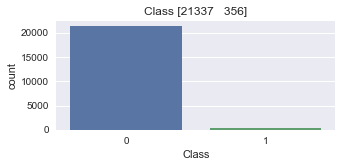

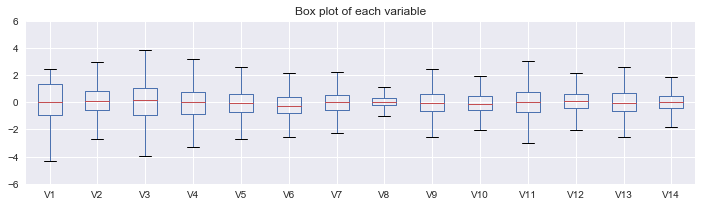

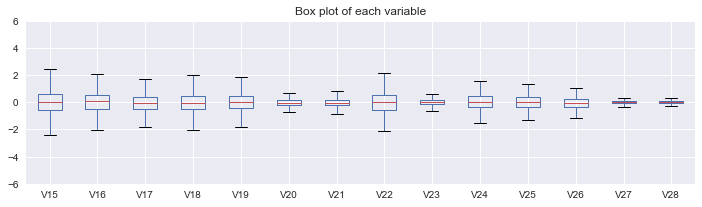

In [16]:
plt.figure(figsize=(5, 2))
sns.countplot(df_raw.Class)
plt.title("Class " + str(df_raw.Class.value_counts().values))
plt.show()
df_raw.iloc[:, :14].plot.box(subplots=False, figsize=(12, 3), title='Box plot of each variable')
plt.ylim(-6, 6)
plt.show()
df_raw.iloc[:, 14:28].plot.box(subplots=False, figsize=(12, 3), title='Box plot of each variable')
plt.ylim(-6, 6)
plt.show()

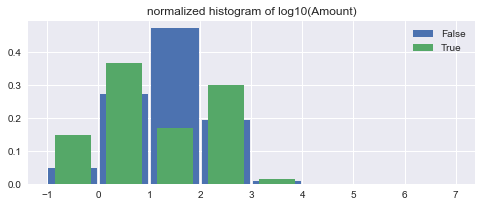

In [4]:
plt.figure(figsize=(8, 3))
plt.hist(np.log10(df_raw.Amount[df_raw.Class == 0] + .1), bins=range(-1, 8), normed=True, rwidth=0.95)
plt.hist(np.log10(df_raw.Amount[df_raw.Class == 1] + .1),  bins=range(-1, 8), normed=True, rwidth=0.7)
plt.legend(['False', 'True'])
plt.title('normalized histogram of log10(Amount)')
plt.show()

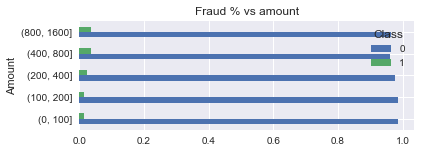

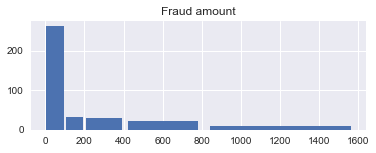

Class,0,1
Amount,,
"(0, 100]",16991,240
"(100, 200]",2115,32
"(200, 400]",1224,31
"(400, 800]",565,22
"(800, 1600]",239,9


Class,0,1
Amount,,
"(0, 100]",0.986072,0.013928
"(100, 200]",0.985095,0.014905
"(200, 400]",0.975299,0.024701
"(400, 800]",0.962521,0.037479
"(800, 1600]",0.963710,0.036290


In [3]:
#  check spending amount vs. fraud
bins = [0, 100, 200, 400, 800, 1600]
(pd.crosstab(pd.cut(df_raw.Amount, bins=bins),
                    df_raw.Class, 
                    normalize='index')
             .plot.barh(title='Fraud % vs amount', figsize=(6, 2)))
plt.show()
df_raw.Amount[df_raw.Class == 1].hist(bins=bins,
                                      figsize=(6, 2), rwidth=0.9)
plt.title('Fraud amount')
plt.show()
display(pd.crosstab(pd.cut(df_raw.Amount, 
                           bins=bins),
            df_raw.Class))
display(pd.crosstab(pd.cut(df_raw.Amount, 
                           bins=bins),
                    df_raw.Class, 
                    normalize='index') )

In [17]:
from sklearn.preprocessing import StandardScaler
df_raw.Amount.describe()
df_raw.Amount[df_raw.Class == 1].mean(), df_raw.Amount[df_raw.Class == 0].mean()
df_raw["Amount"] = StandardScaler().fit_transform(np.log10(Amount + 0.1).values.reshape(-1, 1))
display(df_raw.tail(1))
X, y = df_raw.values[:, :-1], df_raw.values[:, -1]
# print('Raw X std\n', np.std(X, axis=0))
X = StandardScaler().fit_transform(X)
# print('normalized centralized X std \n', np.std(X, axis=0))

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
21692,-0.312369,0.944738,1.430605,0.627951,0.317725,-0.180406,0.793108,-0.104993,-0.493956,0.344477,...,0.118417,0.609081,-0.270644,0.004333,-0.114185,-0.287989,0.232375,-0.023563,-0.14565,0


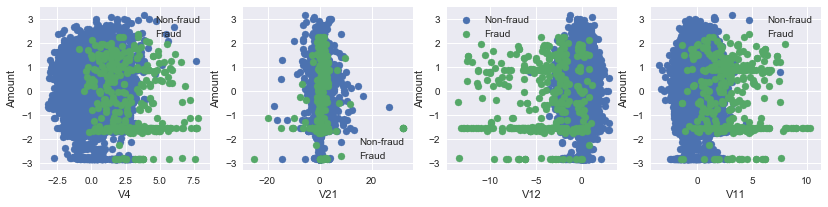

In [5]:
def plot_scatter(X, y, idx=[3, 20, 11, 10], j=28):
    fig, ax = plt.subplots(1, 4, figsize=(14,3))
    for idx, i in enumerate(idx):        
        ax[idx].scatter(X[y == 0, i], X[y == 0, j])
        ax[idx].scatter(X[y == 1, i], X[y == 1, j])
        ax[idx].legend(['Non-fraud', 'Fraud'])
        ax[idx].set_xlabel(df_raw.columns[i])
        ax[idx].set_ylabel(df_raw.columns[j])
    plt.show()
plot_scatter(X, y)

Exploratory study shows the positive case is less than 1%. The data is not linearly separable. 

## Step 3: Build classification model
1. first function take classifier and build model, visualize results
2. k-folds cross-validation in train and cross-validation data, test with test dataset.

In [18]:
def run_clf(clf, X, y, test_size=0.33):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        stratify=y)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_score = clf.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print('  train and test score ', clf.score(X_test, y_test),
            clf.score(X_train, y_train))
    print('  precision, recall, F1_score', 
                  precision_score(y_test, y_pred),
                  recall_score(y_test, y_pred), 
                  f1_score(y_test, y_pred))
    # print('  confusioni matrix\n', confusion_matrix(y_test, y_pred))
    roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_score)
    roc_auc = auc(fpr, tpr)
    plt.subplots(1, 3, figsize=(12, 3))
    plt.subplot(131)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='auc {:.2f}'.format(roc_auc))
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.legend()
    
    plt.subplot(132)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_score)
    pr_auc = auc(precision, recall, reorder=True)
    plt.plot(recall, precision, label='auc {:.2f}'.format(pr_auc))
    plt.title(clf.__class__)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend()
    
    plt.subplot(133)
    sns.heatmap(confusion_matrix(y_test, y_pred),
                cmap="coolwarm_r",annot=True, fmt='d',linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("Actual class")
    plt.show()
    return clf
# test dummy classifier
# clf = DummyClassifier()
# run_clf(clf, X, y)

In [15]:
# stratified kfolds cross validation        
def run_kfold(clf, X, y, k=3, test_size=0.33):
    (X_train, X_test,
     y_train, y_test) = train_test_split(X, y,
                                         test_size=test_size,
                                         stratify=y)
    scores = []
    kfold = StratifiedKFold(n_splits=k)
    kfold.get_n_splits(X_train, y_train)
    for k, (train_idx, test_idx) in enumerate(kfold.split(X_train, y_train)):
        clf.fit(X_train[train_idx], y_train[train_idx])
        score = (clf.score(X_train[test_idx], y_train[test_idx]),
                 f1_score(y_train[test_idx],
                          clf.predict(X_train[test_idx])),
                 clf.score(X_test, y_test),
                 f1_score(y_test, clf.predict(X_test)))
        scores.append(score)
        # print('kfold cv score, f1_score ', scores)
    scores = np.array(scores)
    print('  Mean score: kfold cross_validation {0:.3f} test {1:.3f} \n\
    F1_score: kfold cross_validation {2:.3f} test {3:.3f}'.format(
          *np.mean(scores, axis=0)))
    print('  Mean score std: kfold cross_validation {0:.3f} test {1:.3f} \n\
    F1_score std: kfold cross_validation {2:.3f} test {3:.3f}'.format(*np.std(scores, axis=0)))
# run_kfold(clf, X, y)

From test above, we see DummyClasifier is not good and k-fold cross validation doesn't various much. 

## Step 4 testing different machine learning models  
1. LogisticRegression with regularization  
2. Tree  
3. Boosting  
4. RF detailed study of feature importance

# # # # # # # # # # # # # # # # # # # # l2
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      7042
        1.0       0.97      0.84      0.90       117

avg / total       1.00      1.00      1.00      7159

  train and test score  0.996926945104 0.996146965736
  precision, recall, F1_score 0.970297029703 0.837606837607 0.899082568807


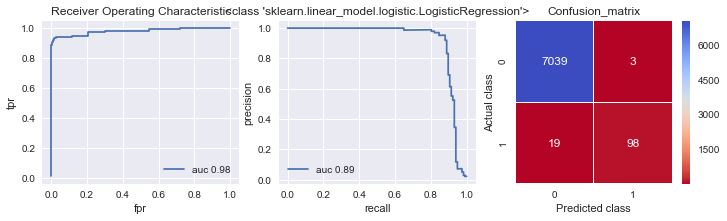

# # # # # # # # # # # # # # # # # # # # l1
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      7042
        1.0       0.96      0.77      0.85       117

avg / total       1.00      1.00      1.00      7159

  train and test score  0.995669786283 0.996422182469
  precision, recall, F1_score 0.957446808511 0.769230769231 0.85308056872


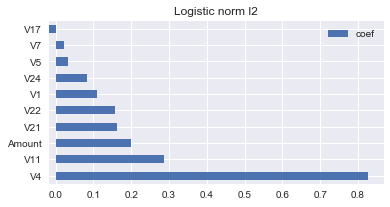

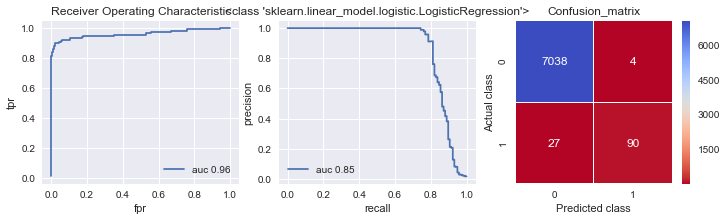

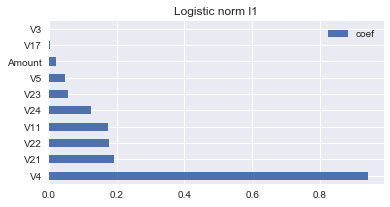

# # # # # # # # # # # # # # # # # # # # do cross validation
  Mean score: kfold cross_validation 0.996 test 0.873 
    F1_score: kfold cross_validation 0.996 test 0.861
  Mean score std: kfold cross_validation 0.001 test 0.029 
    F1_score std: kfold cross_validation 0.000 test 0.003


In [19]:
from sklearn.linear_model import LogisticRegression

# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, penalty in enumerate(['l2', 'l1']):
    print('# '*20 + penalty)
    clf = LogisticRegression(penalty=penalty, C=0.5)
    clf = run_clf(clf, X, y)
    # sorted(zip(clf.coef_[0], df_raw.columns), reverse=True)
    (pd.DataFrame(index=df_raw.columns[: -1].values,
                 data=clf.coef_[0],
                 columns=['coef'])
       .nlargest(10, columns='coef')
       .plot(kind='barh', ax=None, figsize=(6, 3)))
    plt.title('Logistic norm ' + penalty)
plt.show()

print('# '*20 + 'do cross validation')
run_kfold(clf, X, y)

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      7042
        1.0       0.75      0.81      0.78       117

avg / total       0.99      0.99      0.99      7159

  train and test score  0.992596731387 1.0
  precision, recall, F1_score 0.753968253968 0.811965811966 0.781893004115


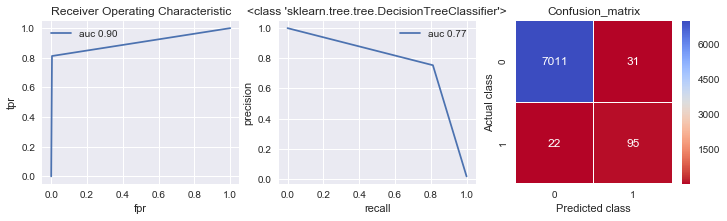

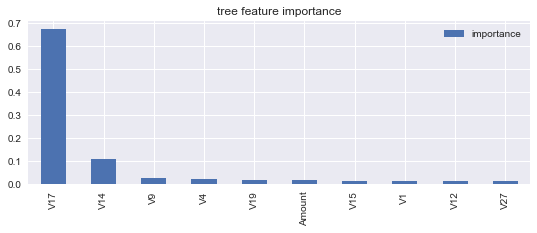

In [20]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=20, max_features=20)
run_clf(clf, X, y)

(pd.DataFrame(index=df_raw.columns[: -1],
              data=clf.feature_importances_,
              columns=['importance'])
     .nlargest(10, columns='importance')
     .plot.bar(figsize=[9, 3], title='tree feature importance'))
plt.show()

## Step 5: Boosting and ensemble classifiers

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      7042
        1.0       0.87      0.79      0.83       117

avg / total       0.99      0.99      0.99      7159

  train and test score  0.994552311775 1.0
  precision, recall, F1_score 0.867924528302 0.786324786325 0.825112107623


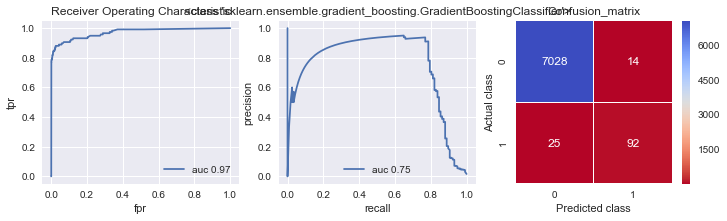

  Mean score: kfold cross_validation 0.995 test 0.836 
    F1_score: kfold cross_validation 0.995 test 0.838
  Mean score std: kfold cross_validation 0.001 test 0.027 
    F1_score std: kfold cross_validation 0.000 test 0.005


In [21]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
run_clf(clf, X, y)
# run_kfold(clf, X, y)

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      7042
        1.0       0.96      0.83      0.89       117

avg / total       1.00      1.00      1.00      7159

  train and test score  0.996647576477 1.0
  precision, recall, F1_score 0.960396039604 0.82905982906 0.889908256881


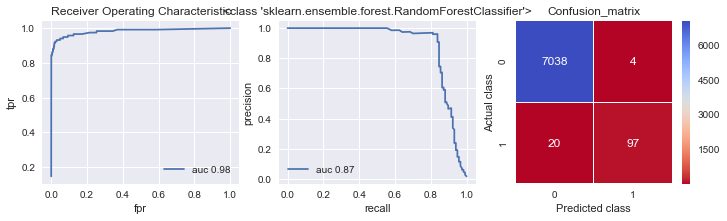

  Mean score: kfold cross_validation 0.997 test 0.895 
    F1_score: kfold cross_validation 0.997 test 0.887
  Mean score std: kfold cross_validation 0.000 test 0.009 
    F1_score std: kfold cross_validation 0.000 test 0.002
Feature importance
('V14', 0.19730037509397091)
('V10', 0.14370281119187756)
('V12', 0.1200946918120977)
('V17', 0.10756030754849277)
('V11', 0.06695618049791828)
('V16', 0.064725976534140847)
('V4', 0.05054915821486456)
('V3', 0.040080887085791668)
('V9', 0.031232861834720422)
('V18', 0.021798670320136174)
('V7', 0.014525378569240638)
('V2', 0.013086142556103384)
('V6', 0.012162111713404762)
('V5', 0.010041264507663399)
('Amount', 0.0097995252888264609)
('V19', 0.0084348735497828623)
('V8', 0.0082908015278901522)
('V27', 0.0081718678994870727)
('V1', 0.0080603995972319403)
('V15', 0.0077106231663463583)
('V21', 0.007600151999407341)
('V20', 0.0075603911149854817)
('V22', 0.0072239782890914494)
('V28', 0.0067724869171162817)
('V13', 0.0066950325844108531)
('V25', 

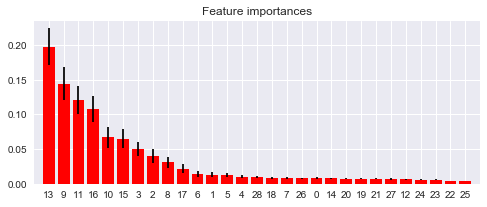

In [22]:
from sklearn.ensemble import RandomForestClassifier
np.set_printoptions(precision=3)
clf = RandomForestClassifier(n_estimators=200,
                             max_depth=20)
run_clf(clf, X, y)
run_kfold(clf, X, y)

from operator import itemgetter
from pprint import pprint
print('Feature importance')
for _ in sorted(zip(df_raw.columns[: -1], clf.feature_importances_), 
                key=itemgetter(1), reverse=True):
    print(_) 
importances = np.mean([c.feature_importances_ for c in clf.estimators_], axis=0) # clf.feature_importances_
std = np.std([c.feature_importances_ for c in clf.estimators_], axis=0) / 10
indices = np.argsort(importances)[::-1]
# Plot the feature importances of the forest
plt.figure(figsize=(8,3))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices],
        yerr=std[indices], color='r',align='center')
plt.xticks(range(len(importances)), indices)
plt.xlim([-1, len(importances)])
plt.show()

### based on above study, roc_curve is not good for imbalanced classification, precision and recall should be used.
## Step 6 Optional: Grid search for parameter optimization with RF, pipeline

In [13]:
from sklearn.model_selection import GridSearchCV
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=22)
parameter_grid = {'n_estimators':[50,200],'min_samples_leaf':[1,2]}
grid_search = GridSearchCV(estimator=RandomForestClassifier(),
                           param_grid=parameter_grid,
                           scoring='f1',
                           cv=kfold)
grid_search.fit(X,y) #gridSearch can use all inputs X,y
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
grid_search.cv_results_

Best score: 0.8930622821233003
Best parameters: {'min_samples_leaf': 1, 'n_estimators': 200}


{'mean_fit_time': array([  5.233,  21.261,   5.544,  21.676]),
 'mean_score_time': array([ 0.076,  0.291,  0.07 ,  0.291]),
 'mean_test_score': array([ 0.891,  0.893,  0.893,  0.892]),
 'mean_train_score': array([ 0.999,  1.   ,  0.918,  0.913]),
 'param_min_samples_leaf': masked_array(data = [1 1 2 2],
              mask = [False False False False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [50 200 50 200],
              mask = [False False False False],
        fill_value = ?),
 'params': ({'min_samples_leaf': 1, 'n_estimators': 50},
  {'min_samples_leaf': 1, 'n_estimators': 200},
  {'min_samples_leaf': 2, 'n_estimators': 50},
  {'min_samples_leaf': 2, 'n_estimators': 200}),
 'rank_test_score': array([4, 1, 2, 3]),
 'split0_test_score': array([ 0.918,  0.919,  0.924,  0.92 ]),
 'split0_train_score': array([ 0.998,  1.   ,  0.906,  0.894]),
 'split1_test_score': array([ 0.874,  0.874,  0.873,  0.874]),
 'split1_train_score': array([ 1.   ,  1.   ,  0.926,  0.

## Undersampling
For data imbalance problems, mostly handled in three steps.  
Over-sample the minority class.  
Under-sample the majority class.  
Synthesize new minority classes.  

n_positive, ratio, len(y) 356 11 21693
values counts 
 0.0    3916
1.0     356
dtype: int64
Test Accuracy 0.9812734082397003, 
F1 score 0.8780487804878049
[[976   2]
 [ 18  72]]


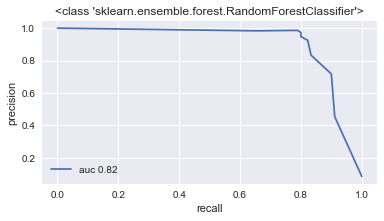

In [30]:
# Conduct under sampling for imbalanced dataset
# http://contrib.scikit-learn.org/imbalanced-learn/stable/install.html
# from imblearn.over_sampling import SMOTE
def sample_imbalance(X, y, ratio):
    idx_neg = pd.DataFrame(X)[y == 0].index
    print('n_positive, ratio, len(y)', len(X) - len(idx_neg), ratio, len(y))
    idx_sample = np.random.choice(idx_neg, ratio * sum(y == 1), replace=False)
    X_res = np.concatenate([X[idx_sample], X[y == 1]], axis=0)
    y_res = np.concatenate([y[idx_sample], y[y == 1]], axis=0)
    print('values counts \n', pd.value_counts(y_res))
    return X_res, y_res
X_res, y_res = sample_imbalance(X, y, 11)
pipe_rf = Pipeline([('scaler', StandardScaler()), 
                    ('forest', RandomForestClassifier()) ])
train_idx, test_idx = train_test_split(pd.DataFrame(X_res).index)
pipe_rf.fit(X_res[train_idx], y_res[train_idx])
print('Test Accuracy {0}, '.format(pipe_rf.score(X_res[test_idx], y_res[test_idx])))
print('F1 score {0}'.format(f1_score(y_res[test_idx], pipe_rf.predict(X_res[test_idx]))))
print(confusion_matrix(y_res[test_idx], pipe_rf.predict(X_res[test_idx])))

precision, recall, _ = precision_recall_curve(y_res[test_idx],
                                              pipe_rf.predict_proba(X_res[test_idx])[:, 1])
pr_auc = auc(precision, recall, reorder=True)
plt.figure(figsize=(6, 3))
plt.plot(recall, precision, label='auc {:.2f}'.format(pr_auc))
plt.title(clf.__class__)
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.show()


## Summary 
### Randomforest performance is good with F1_score 0.86. MLP, boosting, Undersampling didn't improve model accuracy here.  More study might improve its performance. 
### For unbalanced data, it is important to use F1_score, precision, recall, and stratified split.
### Feature v4, v11, v21, v22 are important for logistic regression model

## Extended studies
Original data was transformed using PCA, so I did further PCA to see variable difference

Test Accuracy 0.995575221238938, 
F1 score 0.8536585365853658


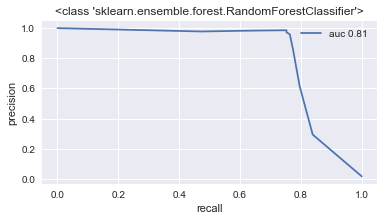

In [26]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

train_idx, test_idx = train_test_split(pd.DataFrame(X).index)
pipe_rf = Pipeline([('scaler', StandardScaler()), 
                    ('pca', PCA(n_components=18)),
                    ('forest', RandomForestClassifier()) ])
pipe_rf.fit(X[train_idx], y[train_idx])
print('Test Accuracy {0}, '.format(pipe_rf.score(X[test_idx], y[test_idx])))
print('F1 score {0}'.format(f1_score(y[test_idx], pipe_rf.predict(X[test_idx]))))
precision, recall, _ = precision_recall_curve(y[test_idx],
                                              pipe_rf.predict_proba(X[test_idx])[:, 1])
pr_auc = auc(precision, recall, reorder=True)
plt.figure(figsize=(6,3))
plt.plot(recall, precision, label='auc {:.2f}'.format(pr_auc))
plt.title(clf.__class__)
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.show()

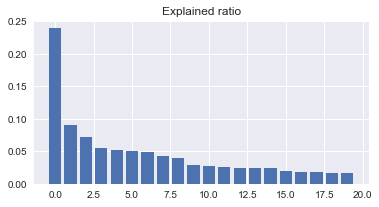

In [122]:
# PCA only for unsupervised learning
pca = PCA(n_components=20)
pca.fit(X)
plt.figure(figsize=(6, 3))
plt.bar(range(20), pca.explained_variance_ratio_)
plt.title('Explained ratio')
plt.show()

### MLP neural network  and Support vector machine

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      7042
        1.0       0.95      0.81      0.88       117

avg / total       1.00      1.00      1.00      7159

  train and test score  0.996228523537 0.998761524701
  precision, recall, F1_score 0.95 0.811965811966 0.875576036866
  confusioni matrix
 [[7037    5]
 [  22   95]]


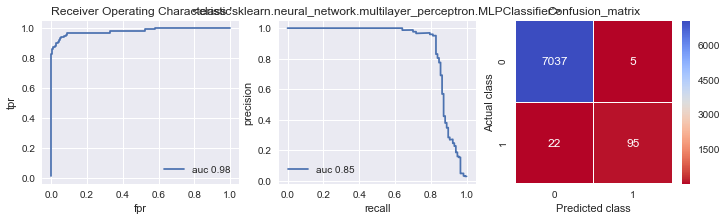

kfold cross_validation and test mean score, F1_score 
 [ 0.996  0.859  0.996  0.863]
std  [ 0.001  0.025  0.     0.015]


In [140]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()
run_clf(clf, X, y)
run_kfold(clf, X, y)

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      7042
        1.0       0.95      0.78      0.85       117

avg / total       1.00      1.00      1.00      7159

  train and test score  0.995669786283 0.999862391633
  precision, recall, F1_score 0.947916666667 0.777777777778 0.854460093897
  confusioni matrix
 [[7037    5]
 [  26   91]]


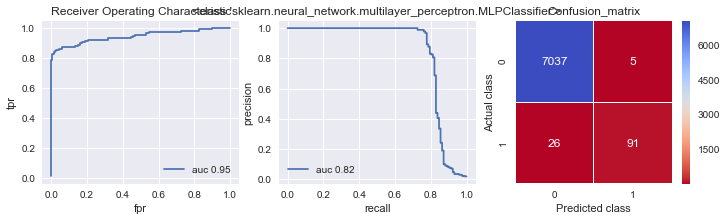

In [143]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100, 31), random_state=22)
run_clf(clf, X, y)
# run_kfold(clf, X, y)

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      7042
        1.0       0.98      0.81      0.89       117

avg / total       1.00      1.00      1.00      7159

  train and test score  0.996647576477 0.995940553186
  precision, recall, F1_score 0.979381443299 0.811965811966 0.88785046729
  confusioni matrix
 [[7040    2]
 [  22   95]]


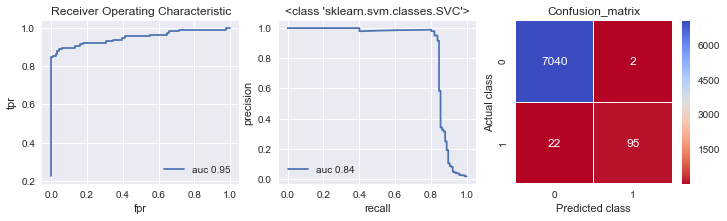

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [42]:
from sklearn.svm import SVC
clf = SVC(C=1.0, kernel='linear', probability=True)  # 'rbf'
clf = run_clf(clf, X, y)

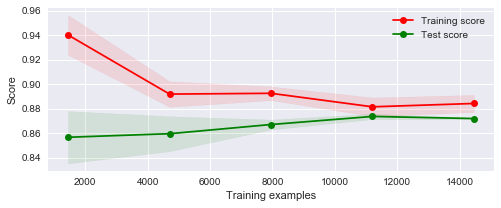

In [46]:
from sklearn.model_selection import learning_curve, validation_curve
for train_size in [0.33]:
    train_sizes = np.linspace(.1, 1.0, 5)
    train_sizes, train_scores, test_scores = learning_curve(
         LogisticRegression(), X, y, train_sizes=train_sizes, 
         cv=3, scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 3))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [41]:
train_scores, test_scores

(array([[ 0.876,  0.889,  0.906]]), array([[ 0.861,  0.868,  0.869]]))